<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [963]:
%%capture
pip install pyswarms

In [964]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [965]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'

In [966]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [967]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [968]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [969]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [970]:
 # Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)
    return fator

In [971]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [972]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [973]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [974]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [975]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/data.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


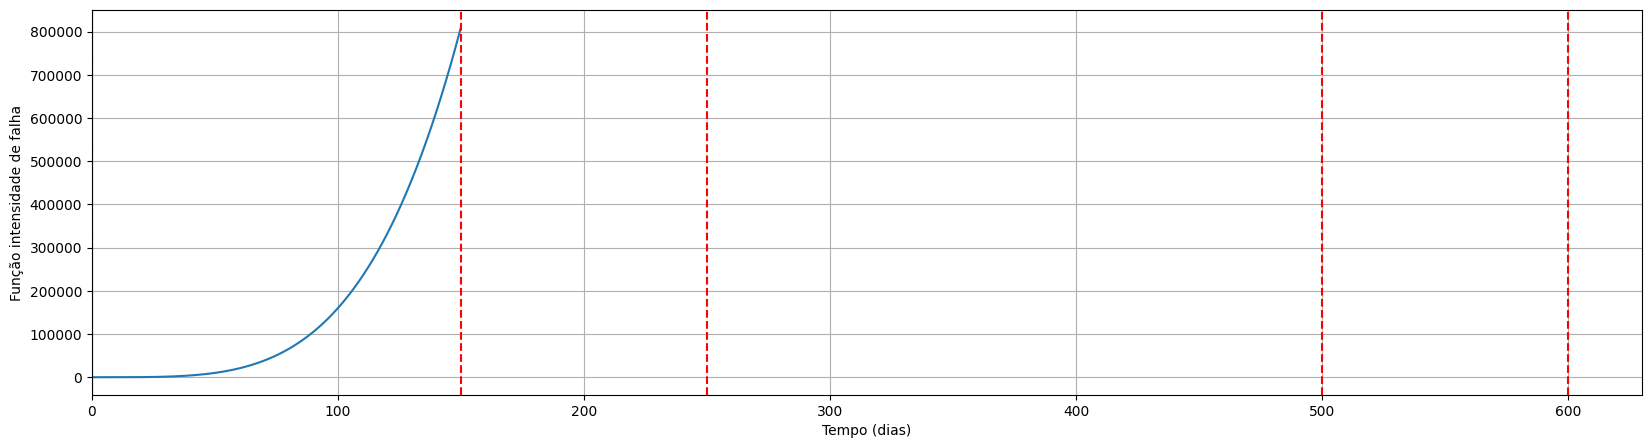

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [976]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [977]:
def objective_st(x):
    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    # Criação de variáveis para os parâmetros


    global s
    T = [0]
    s_row = []
    cont = 0
    t = df['t']
    k = df['k']
    ck = df['c'].max()
    n = []
    s = []
    # Iterar sobre os elementos de x usando np.nditer()
    with np.nditer(x, op_flags=['readwrite']) as it:
        for number in it:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    for row in range(m):
        s.append(s_row)

    if ck == 0:
        return MAX_VALUE_CUSTO

    num_ciclos = ck

    for k in range(m):
        n.append(list(df['n'][k * ck:(k + 1) * ck]))
        s_row = []
        for j in range(num_ciclos):
            s_row.append(df['s'][k * ck + j])
        s.append(s_row)

   # Obter os tempos para manutenções preventivas
    T = list(df['T'][:m])
    tempos_mp = T[1:]

    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    termos_somatorio = [((1 / (lamb ** beta)) * (T[1] ** beta))]
    numero_medio_falhas = [0, ((1 / (lamb ** beta)) * (T[1] ** beta))]

    for i in range(ck - 1):
        termo = (((T[i + 2] - fator[i] * T[i + 1]) ** beta) - (((1 - fator[i]) * T[i + 1]) ** beta)) * (1 / (lamb ** beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    final = 730
    termo = (((final - fator[ck - 1] * T[ck]) ** beta) - (((1 - fator[ck - 1]) * T[ck]) ** beta)) * (1 / (lamb ** beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    Ctotal = []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i + 1] - mi[i]) * CMC) / (T[i + 1] - T[i]))

    cmp = custo_mp(s[0][ck - 1], CMP)
    Ctotal.append((cmp + (mi[ck + 1] - mi[ck]) * CMC) / (final - T[ck]))
    Custo = np.sum(Ctotal)

    # Formatar o valor do custo
    Custo_formatado = format(Custo, '.2f')
    Custo_formatado = Custo_formatado.replace('.', '').replace(',', '.')

    print("")
    print("=========================================================================")
    print("")

     # Imprimir o custo total para manutenções preventivas
    print("Custo Total:", Custo_formatado)

     # Imprimir o número de ciclos de manutenção
    print("Número de Ciclos de Manutenção:", num_ciclos)

    # Imprimir os tempos para manutenções preventivas
    print("Tempos para Manutenções Preventivas:", tempos_mp)

    # Imprimir os tempos para manutenções preventivas
    print("Número de Sisemas:", m)

    # Imprimir a severidade para cada ciclo de manutenção
    print("=========================================================================")
    print("")
    for k in range(m):
        for i in range(num_ciclos):
            if not np.isnan(s[k][i]):
                print("Severidade para Ciclo de Manutenção", i+1, "do Sistema", k+1, ":", s[k][i])

    return Custo

In [978]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-07-07 00:27:26,940 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   2%|▏         |2/100, best_cost=7.07e+10



Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:   7%|▋         |7/100, best_cost=7.07e+10



Custo Total: 25014012933460
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best:   9%|▉         |9/100, best_cost=7.07e+10

 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.5


Custo Total: 26586411604262
Número de Ciclos de Manutenção: 4


pyswarms.single.global_best:  13%|█▎        |13/100, best_cost=3.57e+10



Custo Total: 7065288910973
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Si

pyswarms.single.global_best:  16%|█▌        |16/100, best_cost=3.57e+10



Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:  20%|██        |20/100, best_cost=3.57e+10

: 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.5


Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutençã

pyswarms.single.global_best:  22%|██▏       |22/100, best_cost=3.57e+10



Custo Total: 3573205574569
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best:  25%|██▌       |25/100, best_cost=3.57e+10

do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.5


Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de

pyswarms.single.global_best:  30%|███       |30/100, best_cost=3.57e+10



Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:  35%|███▌      |35/100, best_cost=3.57e+10

5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.5


Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manuten

pyswarms.single.global_best:  39%|███▉      |39/100, best_cost=3.57e+10



Custo Total: 25014012951152
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best:  39%|███▉      |39/100, best_cost=3.57e+10



Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best:  43%|████▎     |43/100, best_cost=3.57e+10

 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.5


Custo Total: 25014012951152
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manu

pyswarms.single.global_best:  45%|████▌     |45/100, best_cost=3.57e+10

do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.75


Custo Total: 25014012951152
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para 

pyswarms.single.global_best:  49%|████▉     |49/100, best_cost=3.57e+10



Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:  53%|█████▎    |53/100, best_cost=3.57e+10

 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.75


Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0,

pyswarms.single.global_best:  57%|█████▋    |57/100, best_cost=3.57e+10

0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.75


Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutençã

pyswarms.single.global_best:  62%|██████▏   |62/100, best_cost=3.57e+10



Custo Total: 25014012951152
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best:  62%|██████▏   |62/100, best_cost=3.57e+10



Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:  65%|██████▌   |65/100, best_cost=3.57e+10



Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:  69%|██████▉   |69/100, best_cost=3.57e+10

 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.75


Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tem

pyswarms.single.global_best:  72%|███████▏  |72/100, best_cost=3.57e+10

0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.75


Custo Total: 25014012951152
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manute

pyswarms.single.global_best:  76%|███████▌  |76/100, best_cost=3.57e+10

 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.75


Custo Total: 25014012951152
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manut

pyswarms.single.global_best:  82%|████████▏ |82/100, best_cost=3.57e+10

: 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.5


Custo Total: 25014012951152
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.

pyswarms.single.global_best:  84%|████████▍ |84/100, best_cost=3.57e+10

 0.75


Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutençã

pyswarms.single.global_best:  87%|████████▋ |87/100, best_cost=3.57e+10

: 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.75


Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manut

pyswarms.single.global_best:  91%|█████████ |91/100, best_cost=3.57e+10

 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.75


Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manu

pyswarms.single.global_best:  97%|█████████▋|97/100, best_cost=3.57e+10

3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 :

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.57e+10
2023-07-07 00:27:33,947 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90670534 5.44308544 6.40257978 0.71557119 5.4114084  2.92531877
 0.97150634 4.15619933 2.48899586 1.16245292 3.44994754 4.92876869
 5.58847483 1.64712196 4.70149396 5.11959951 6.43360863 1.54355407
 1.51882486 5.49063768 1.32242633 6.32027656 5.05049151 6.55971238]
2023-07-07 00:27:33,950 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.75


Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manu

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:33,994 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90625033 5.44828997 4.10267608 0.7177004  5.4149717  2.92678286
 0.9688257  4.15629682 2.49358444 1.43060277 3.44938128 4.93083629
 5.59013194 1.65784915 2.09609    5.11905428 6.43343964 1.54409949
 2.56039844 5.62956572 1.34349588 6.31631184 0.68570095 6.54051945]
2023-07-07 00:27:33,996 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205574569
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:34,196 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90803317 5.4488315  6.16781635 0.70131512 5.41477203 2.92542271
 0.9676362  4.15489029 2.4913995  0.91728542 3.44910474 4.92975569
 5.59085791 1.65442587 2.25461228 5.11878953 6.4333797  1.54401153
 3.39945998 4.35030492 1.3561313  6.31945821 6.93793654 6.53578395]
2023-07-07 00:27:34,200 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


: 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.5


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:34,286 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90932063 5.44760494 0.33712812 0.6905885  5.41440157 2.92416742
 0.96757053 4.15363369 2.48871234 1.20572228 3.44886347 4.92875438
 5.59096865 1.64991416 1.88779468 5.1187224  6.43336086 1.54381198
 4.60633788 2.71981295 1.36602365 6.32235017 5.34075021 6.5340594 ]
2023-07-07 00:27:34,291 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205574569
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:34,336 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.9099869  5.44580325 2.16065257 0.68808426 5.41392432 2.9233631
 0.96805924 4.1530106  2.48634001 2.15803408 3.44866295 4.92785587
 5.59099333 1.64584586 1.05040635 5.11878924 6.43335879 1.54357023
 5.7505364  0.78934055 1.3740693  6.32445322 3.16026865 6.53658612]
2023-07-07 00:27:34,343 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:34,542 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.91042773 5.44416468 3.25972879 0.68853554 5.41305688 2.92288646
 0.96879048 4.15324644 2.48423534 3.70187983 3.44883921 4.92718943
 5.59096606 1.64247906 0.41533635 5.11894099 6.43341974 1.5433483
 6.82802158 6.24122411 1.37005579 6.32616582 0.89938496 6.54258616]
2023-07-07 00:27:34,553 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.75


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.57e+10



Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:34,607 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.9100182  5.44258698 3.6964093  0.69682451 5.41192152 2.92303064
 0.9699864  4.15376138 2.48353982 5.20998358 3.44929738 4.92682517
 5.59031951 1.64002939 6.39547951 5.11917677 6.43349313 1.54316245
 0.12232298 4.11304861 1.35871074 6.32718811 5.60924633 6.55076101]
2023-07-07 00:27:34,609 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:34,700 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90889293 5.44131321 3.71678509 0.70472057 5.41086014 2.92346091
 0.97123196 4.1547072  2.48312112 6.09552032 3.44972466 4.92666213
 5.58943363 1.63843021 4.34113228 5.11950529 6.43356381 1.54309691
 1.28192935 1.61



Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:34,817 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90730935 5.44019611 3.18381573 0.71390476 5.40990901 2.92419906
 0.9724064  4.15580547 2.48448105 0.56880543 3.4501153  4.92691051
 5.58860733 1.63865718 1.86991127 5.11982036 6.43363015 1.54309922
 3.06987061 6.22872833 1.32521828 6.32412727 6.92823812 6.56584257]
2023-07-07 00:27:34,824 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:35,207 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90585457 5.43944935 2.84105013 0.72265979 5.40940319 2.92502783
 0.97339022 4.15686206 2.4860311  2.76513944 3.45044391 4.92762292
 5.58783488 1.64024047 6.54071055 5.12006968 6.43368602 1.54321222
 5.32606056 3.17618679 1.31018376 6.32122514 3.56214191 6.57212919]
2023-07-07 00:27:35,209 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:35,259 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90477978 5.43959822 2.69235768 0.72992561 5.40952251 2.92581727
 0.9739399  4.15774826 2.48812901 5.35926377 3.4507327  4.9284577
 5.58723436 1.64231111 3.39758583 5.12026189 6.43372353 1.54340141
 0.16911431 6.80085844 1.29723917 6.31860199 6.99649396 6.57539135]
2023-07-07 00:27:35,261 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:35,291 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.9043168  5.44005228 2.45400134 0.73220721 5.40975334 2.92643194
 0.97437778 4.15825802 2.49007256 0.53667881 3.45093497 4.92926432
 5.58689944 1.64475149 6.89898965 5.12041503 6.43373738 1.54357753
 2.79070487 2.93270266 1.2919365  6.31625856 3.06036586 6.57622404]
2023-07-07 00:27:35,293 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:35,484 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90400521 5.44136494 2.53000687 0.73065532 5.4103132  2.92689426
 0.97475533 4.15811524 2.49164168 3.32459317 3.45092609 4.9298483
 5.58681137 1.64715632 2.93782815 5.12051763 6.43372878 1.5437333
 5.49488289 5.94286084 1.29035717 6.31481722 5.83409572 6.57676629]
2023-07-07 00:27:35,485 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


: 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.5


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.57e+10



Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:35,572 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90383445 5.44296545 2.6649808  0.72802626 5.41111744 2.92711583
 0.97486944 4.15761557 2.49226185 5.90265979 3.45077283 4.930192
 5.58698169 1.64931665 6.13701602 5.12049892 6.43370827 1.54386642
 0.59504283 1.51676259 1.29671058 6.31376922 1.17484111 6.57677911]
2023-07-07 00:27:35,574 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:35,617 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90373682 5.44443074 2.56481391 0.72302343 5.41188818 2.92696608
 0.97431493 4.15686066 2.49226022 1.06731776 3.45058081 4.93027512
 5.58735271 1.6511105  1.73378432 5.12039753 6.43366838 1.54393158
 3.22581615 4.2466



Custo Total: 3573205574569
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:35,906 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.9041345  5.44553766 2.72510843 0.71753837 5.41250892 2.92654501
 0.97332381 4.1561318  2.49213748 3.72887911 3.45025086 4.9299757
 5.58770704 1.65195278 4.34806447 5.12020868 6.43361808 1.54387941
 6.04704818 6.95244289 1.32041923 6.31411721 6.24964797 6.57532928]
2023-07-07 00:27:35,910 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.5


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:35,977 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90463226 5.44596481 3.1171031  0.71219314 5.41275312 2.92612434
 0.97241596 4.15547599 2.49189862 6.4923016  3.44995128 4.92955535
 5.58808066 1.65126742 6.75284731 5.1199198  6.43357259 1.54378555
 1.87234932 2.19676664 1.33264189 6.31479686 1.41461163 6.57033461]
2023-07-07 00:27:35,978 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:36,025 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90522961 5.445818   3.51570662 0.70768577 5.41276214 2.92568972
 0.97137544 4.15503149 2.49124048 1.66980738 3.44968138 4.92917164
 5.58848274 1.65013738 1.52187858 5.11961759 6.43354015 1.54365689
 5.02091697 4.34773848 1.34286923 6.31600219 3.77994792 6.56486431]
2023-07-07 00:27:36,028 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:36,120 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90611257 5.44494107 3.42341611 0.70407307 5.41272698 2.92526197
 0.97044379 4.15467257 2.49021259 4.20470628 3.44951227 4.92880324
 5.58884411 1.64844452 3.41201868 5.11934523 6.43351245 1.54352687
 0.73672077 6.50866299 1.34929171 6.31814314 6.18766083 6.55861259]
2023-07-07 00:27:36,123 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:36,473 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90691537 5.44410054 2.83494453 0.70380799 5.41268886 2.92488467
 0.96977818 4.15475389 2.48925603 6.43647453 3.44947677 4.92846266
 5.58914738 1.64684122 5.44707802 5.11912356 6.43350438 1.54341574
 3.92484314 1.35451498 1.35403335 6.32047767 1.23657252 6.55324276]
2023-07-07 00:27:36,478 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.5


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:36,508 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90760768 5.44315211 1.65945127 0.70456041 5.41255883 2.92461014
 0.96942719 4.15510916 2.488325   1.90052296 3.4494574  4.92824225
 5.58935522 1.6454596  0.19679549 5.1189725  6.43352468 1.54332199
 0.04462116 3.47952076 1.35427703 6.32254836 4.18809986 6.5492298 ]
2023-07-07 00:27:36,510 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 25014012951152
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:36,556 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.908129   5.4422892  0.58885997 0.7084306  5.41210849 2.9245747
 0.96966337 4.15564461 2.48768631 4.66855635 3.44952999 4.92806706
 5.58937561 1.64459942 2.95828309 5.11890062 6.43355161 1.54326409
 3.91460414 5.7461973  1.34594754 6.32377119 6.9419154  6.54622536]
2023-07-07 00:27:36,558 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:36,920 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90832305 5.4416562  6.72539915 0.71376589 5.41151115 2.92463625
 0.97017871 4.15618038 2.48718077 0.21776585 3.44969923 4.92791326
 5.58927704 1.64446478 5.86158274 5.1188611  6.43357805 1.54329682
 0.74511856 0.77877618 1.33306488 6.32394685 1.85707066 6.54718303]
2023-07-07 00:27:36,924 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.5


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:36,980 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90807248 5.4414254  5.19960052 0.71874868 5.41096183 2.92483002
 0.97092204 4.15666291 2.48716794 3.4882817  3.44992271 4.92795004
 5.58900842 1.64511585 1.3890229  5.1188569  6.43360897 1.54334806
 4.97668829 2.97277665 1.3190951  6.32337492 4.44368847 6.54919985]
2023-07-07 00:27:36,982 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:37,022 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90749916 5.44159094 3.40063441 0.72322324 5.41056572 2.92512326
 0.97159891 4.15709624 2.48734043 6.8035494  3.45012768 4.92814235
 5.58873135 1.64628224 4.03849916 5.11904871 6.4336368  1.54341211
 2.08260939 5.13937065 1.30675712 6.32238508 6.80231422 6.55120677]
2023-07-07 00:27:37,025 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:37,071 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90693478 5.44185416 1.3176223  0.72609763 5.41024298 2.925439
 0.97219909 4.15723996 2.48791925 3.34126833 3.45027704 4.92838607
 5.58844083 1.64756602 6.49958068 5.11926832 6.43365632 1.543498
 6.39417721 0.14889251 1.29637936 6.32148627 1.54887942 6.55500227]
2023-07-07 00:27:37,076 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 25014012951152
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:37,394 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90636208 5.44223443 5.81915395 0.72788963 5.40997599 2.92569712
 0.97267373 4.15722426 2.48856136 6.65751658 3.45032605 4.92865562
 5.58818815 1.64869057 1.41630042 5.11953369 6.43366306 1.54357701
 3.21975776 3.10321952 1.29280966 6.32049348 3.38006269 6.55927289]
2023-07-07 00:27:37,395 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:37,449 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90594602 5.44263397 2.99605928 0.72667637 5.40991763 2.92586237
 0.97287904 4.15720218 2.48914344 2.83768612 3.45030165 4.92892077
 5.58801687 1.6495474  4.08223929 5.11978663 6.43366071 1.54364627
 6.90807624 6.10576752 1.29418828 6.31957156 5.19605536 6.56317994]
2023-07-07 00:27:37,451 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:37,502 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90564635 5.44312875 0.53781957 0.72269247 5.41002164 2.9259617
 0.97275568 4.15699628 2.48965502 6.34534804 3.45023935 4.92914609
 5.58786442 1.64984558 6.4852048  5.119983   6.4336492  1.54370458
 2.5628323  1.78404997 1.29861382 6.31894655 6.80789754 6.56590903]
2023-07-07 00:27:37,503 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:37,795 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90562699 5.44356599 5.62764002 0.71885192 5.41028486 2.92596387
 0.97241773 4.15671838 2.49003596 2.47424081 3.45014648 4.92926323
 5.58772835 1.65004895 1.55809456 5.12014062 6.43362922 1.54373338
 5.52414508 5.21836334 1.30911604 6.31863066 0.9457236  6.56680674]
2023-07-07 00:27:37,797 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.75


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:37,866 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90565868 5.44385265 3.3935434  0.71443076 5.41079686 2.92581818
 0.97197375 4.15642197 2.49037197 5.78108418 3.45003221 4.92926432
 5.58766854 1.64938353 3.56708367 5.12022179 6.43361073 1.54372733
 1.49065023 1.31000209 1.31873818 6.31857523 2.58101505 6.56615085]
2023-07-07 00:27:37,872 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:37,913 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90580349 5.44406056 1.3904917  0.7105493  5.41128283 2.9255696
 0.97150984 4.15615197 2.49040178 2.09207705 3.44991114 4.92924971
 5.58777028 1.64878452 5.60264688 5.1201164  6.43359379 1.5437212
 4.86138981 5.14566671 1.32801992 6.31893097 4.54629499 6.56485214]
2023-07-07 00:27:37,919 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 25014012951152
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:38,310 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90600542 5.44416984 5.96594613 0.70782789 5.41172586 2.92531123
 0.97109209 4.1559136  2.49038902 5.72127454 3.44980671 4.92918797
 5.58790847 1.6481781  0.25965367 5.11998946 6.43358099 1.54366605
 0.6520694  1.61365865 1.334792   6.31961616 6.37226097 6.56276081]
2023-07-07 00:27:38,342 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.75


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:38,431 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90624276 5.44396647 3.09600292 0.70749154 5.41206059 2.92508077
 0.97083358 4.1557749  2.49000393 2.1823043  3.44973646 4.92904032
 5.58812804 1.64751511 2.53736974 5.11979684 6.43357646 1.54359454
 4.02672924 5.63413543 1.339961   6.32034943 0.68915008 6.56070985]
2023-07-07 00:27:38,436 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:38,538 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90648176 5.44377516 0.69157944 0.70918293 5.41234689 2.92489452
 0.97076325 4.15576398 2.48941842 5.72456836 3.44967627 4.92885683
 5.58835228 1.64685009 4.84446667 5.11958496 6.43357596 1.54351842
 0.63401882 2.2183568  1.343188   6.32100452 2.20242734 6.55874592]
2023-07-07 00:27:38,541 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:38,696 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.9067214  5.44353598 5.48648305 0.71202052 5.4124768  2.92475875
 0.97081998 4.15581502 2.48883088 2.56643832 3.44966773 4.9286836
 5.5885771  1.64626975 6.90389878 5.11939777 6.43357581 1.54345861
 4.80826371 6.1011211  1.34151728 6.32154109 4.18933316 6.55712615]
2023-07-07 00:27:38,698 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:39,038 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90693654 5.44326807 2.87323812 0.71527313 5.41250357 2.9248045
 0.97095153 4.15587938 2.48832083 6.49398077 3.44966804 4.92852804
 5.58876296 1.64580336 1.23878569 5.11928748 6.43358311 1.54342503
 1.65128068 2.54013349 1.33529996 6.32166445 6.17506641 6.55590807]
2023-07-07 00:27:39,042 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.5


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:39,109 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90709583 5.44302579 0.12026419 0.71826034 5.41246259 2.92485834
 0.97117553 4.15602817 2.48793981 2.49329511 3.44969303 4.92845772
 5.5888614  1.64543739 3.2235558  5.11925373 6.43359668 1.54339854
 5.79845418 6.1121589  1.32700221 6.32136392 0.63234613 6.55587297]
2023-07-07 00:27:39,116 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:39,178 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90721938 5.44281377 5.03406938 0.72076547 5.41238675 2.92492403
 0.9714045  4.15616356 2.4877204  5.8689816  3.44972999 4.92845631
 5.58885921 1.64528385 5.38276596 5.11924977 6.43360889 1.54341748
 3.00185242 2.14247284 1.3189557  6.32107218 2.04170335 6.55657563]
2023-07-07 00:27:39,191 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 3573205574569
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:39,575 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90722623 5.44264135 2.59150078 0.72207552 5.41220608 2.92503422
 0.97161991 4.15629076 2.48789219 1.84441646 3.44978733 4.9285244
 5.58884649 1.64540599 0.30160412 5.1192644  6.43361987 1.54344135
 0.19580498 5.7768707  1.31265992 6.3208031  4.07571341 6.55730187]
2023-07-07 00:27:39,594 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.25


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:39,820 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90708829 5.44255199 0.26414214 0.72135227 5.41190871 2.92517912
 0.97178508 4.15637843 2.48831649 5.10254986 3.44987569 4.928597
 5.58872706 1.64572272 2.82083798 5.11933862 6.43362952 1.54349175
 4.76766904 2.03778769 1.30789513 6.32056055 6.14231974 6.55849357]
2023-07-07 00:27:39,860 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:40,116 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90685589 5.44251166 5.95113568 0.71973756 5.41163459 2.92531682
 0.97191363 4.15644468 2.48887271 1.48147475 3.449976   4.9286631
 5.58860514 1.64621285 5.59172993 5.11941614 6.43363293 1.54354586
 1.96043311 5.81667535 1.30554489 6.3203328  0.93297371 6.55971855]
2023-07-07 00:27:40,124 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:40,194 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90662052 5.44260028 4.07191984 0.71778611 5.41132846 2.92544099
 0.9719801  4.15649377 2.48938024 5.2205843  3.45005935 4.92873137
 5.58846337 1.64671065 0.82801641 5.11953068 6.43363226 1.54359672
 6.32083214 2.1477894  1.30438429 6.32012562 3.42885342 6.5608207 ]
2023-07-07 00:27:40,196 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:40,261 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90641387 5.44273664 1.81152933 0.71572082 5.41107291 2.92552453
 0.9719467  4.15649366 2.48979547 1.2377494  3.45013202 4.92879945
 5.58833592 1.64722965 3.53512876 5.11963903 6.43362642 1.54363386
 3.1531134  6.10666664 1.30544845 6.3199645  6.05606703 6.56152492]
2023-07-07 00:27:40,268 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 25014012951152
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best:   0%|          |0/1, best_cost=3.57e+10



Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:40,352 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90625203 5.44296142 0.37494267 0.71384791 5.41086143 2.92559333
 0.97182212 4.15647694 2.49012995 4.64142844 3.45018964 4.92885356
 5.58824092 1.64766876 6.12238929 5.11973171 6.43361675 1.54364921
 6.83270129 2.60627371 1.31069418 6.31984116 1.14150173 6.56177384]
2023-07-07 00:27:40,363 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:40,494 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90623019 5.44319711 6.88317033 0.71226922 5.4108318  2.92558381
 0.97163746 4.15644653 2.49036611 0.42516509 3.45022076 4.92889534
 5.58822473 1.6480459  1.14296123 5.11978573 6.43360785 1.54364802
 3.64197904 5.81



Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 :

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:41,105 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90628389 5.4434075  5.73144354 0.71139298 5.41081961 2.92557057
 0.97144416 4.15639716 2.49018059 3.6708511  3.45019832 4.92891622
 5.58822957 1.64817653 3.51551661 5.11979605 6.43359999 1.54363256
 0.32517582 1.61070068 1.32265676 6.3199538  6.59697999 6.56103101]
2023-07-07 00:27:41,109 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.75


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:41,204 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90643769 5.44359577 4.07378744 0.71142317 5.4109676  2.92551651
 0.97128544 4.15634945 2.48993448 6.90896337 3.45013284 4.92890549
 5.58829562 1.64825368 5.73709235 5.11976317 6.43359474 1.54361689
 4.51770734 4.66664524 1.32801991 6.32007304 1.88661677 6.56045713]
2023-07-07 00:27:41,210 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:41,284 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90662783 5.44365019 2.45081159 0.71249085 5.41115609 2.92543748
 0.97120328 4.15627717 2.48958962 3.34380727 3.45005129 4.92887004
 5.58837226 1.64819806 0.59089971 5.11972938 6.43359269 1.54360156
 1.25555375 0.59454218 1.33162409 6.32018184 4.55692281 6.55985699]
2023-07-07 00:27:41,286 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 25014012951152
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:41,823 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90680048e+00 5.44357703e+00 1.14326684e+00 7.13992503e-01
 5.41139734e+00 2.92535960e+00 9.71135493e-01 4.15619139e+00
 2.48916353e+00 6.72035466e+00 3.44995656e+00 4.92883243e+00
 5.58844153e+00 1.64786328e+00 3.34564477e+00 5.11969535e+00
 6.43359097e+00 1.54358606e+00 5.34903535e+00 3.33315360e+00
 1.33235634e+00 6.32028568e+00 3.11622849e-03 6.55930791e+00]
2023-07-07 00:27:41,827 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.75


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:41,900 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90694531 5.44349414 0.61860617 0.71541581 5.41161562 2.92528773
 0.97113124 4.15611629 2.48877521 2.01324731 3.44987114 4.92879652
 5.58851287 1.64736181 5.85658903 5.11964207 6.43359417 1.54356659
 1.97957525 5.92038246 1.33035743 6.32037723 3.44937072 6.5588497 ]
2023-07-07 00:27:41,910 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:41,957 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90705206 5.44330216 0.64247128 0.71670282 5.41178777 2.92522789
 0.97115187 4.15607055 2.48848985 4.57301173 3.44980795 4.92875997
 5.5885663  1.64686924 0.83407745 5.11958845 6.43359705 1.54354586
 5.81671463 1.22239115 1.32723385 6.32043075 6.61184124 6.55854246]
2023-07-07 00:27:41,964 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:42,009 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90709653 5.44312364 0.5758289  0.71777463 5.41192267 2.92519752
 0.97118505 4.15605265 2.48834109 0.4020331  3.44977525 4.92872843
 5.58858912 1.64645313 3.76883176 5.11954211 6.43360123 1.54352955
 2.50033953 4.26822219 1.32412346 6.32047239 2.2097708  6.55850845]
2023-07-07 00:27:42,010 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:42,512 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90702849 5.4429565  0.65164962 0.71813522 5.41193934 2.92518038
 0.97130185 4.15605368 2.48831762 3.71879781 3.44977059 4.92870386
 5.58860889 1.64623351 6.46196528 5.11950685 6.43360711 1.54351638
 6.38437116 0.04156212 1.32085738 6.32047879 4.81166029 6.55850876]
2023-07-07 00:27:42,523 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


: 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:42,681 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90693774 5.44284141 1.31048316 0.71785612 5.41187147 2.92519673
 0.97144243 4.15609659 2.4884633  6.88209707 3.44980418 4.92869371
 5.58859484 1.64615548 1.79868713 5.11949651 6.43361252 1.54351069
 2.16540224 3.56795902 1.31829401 6.32044131 0.1653819  6.55877063]
2023-07-07 00:27:42,683 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 25014012951152
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:42,814 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90680245 5.44274033 2.3504676  0.71740402 5.41170301 2.92524539
 0.97157464 4.15614583 2.48873797 3.0017893  3.4498376  4.92870422
 5.58854833 1.64624554 4.02190001 5.11948785 6.4336171  1.54351128
 5.3042616  6.76503383 1.31661647 6.32038701 3.17844319 6.55928043]
2023-07-07 00:27:42,817 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:43,054 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90667342 5.44271955 3.52667183 0.71693323 5.41150285 2.92530295
 0.97169353 4.15619681 2.48898584 6.06947042 3.44989083 4.92873063
 5.58849895 1.64655722 6.21659206 5.1194993  6.43361902 1.54351647
 0.91498588 2.57468059 1.31665831 6.32032128 6.16380957 6.55980854]
2023-07-07 00:27:43,055 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.75


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:43,107 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90656273 5.44277582 4.38561686 0.71643879 5.41131559 2.92535899
 0.97177085 4.15624311 2.48920897 1.33011248 3.44994152 4.92875613
 5.58845251 1.64699729 1.05142207 5.11952749 6.43361773 1.54353203
 3.96698639 5.28420142 1.31747591 6.32025719 1.6503513  6.56027988]
2023-07-07 00:27:43,108 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205574569
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:43,159 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90647973 5.44291021 4.70564182 0.71595175 5.41117222 2.92540208
 0.97183503 4.15627759 2.48939524 4.0250637  3.44998883 4.92878213
 5.5884153  1.64739919 3.48095741 5.119557   6.43361454 1.54354674
 0.10545605 0.76362979 1.31953661 6.32020433 4.02393548 6.56069424]
2023-07-07 00:27:43,165 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10



Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do


2023-07-07 00:27:43,218 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90641278 5.44303326 4.45795063 0.71544237 5.41104532 2.92542592
 0.97181718 4.15628526 2.48945627 6.69702788 3.45002818 4.92880357
 5.5883978  1.64771365 5.86633579 5.11959066 6.43361007 1.5435612
 3.70509987 3.1734378  1.32224805 6.32017069 6.4622081  6.56083902]
2023-07-07 00:27:43,638 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:43,698 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90643929 5.44314444 4.03717355 0.71500328 5.41098179 2.92541579
 0.97173568 4.1562672  2.48945044 1.91368154 3.45005976 4.9288212
 5.58838258 1.64782312 0.79575857 5.1196229  6.43360603 1.5435741
 0.02924252 5.63853453 1.32473449 6.32015511 1.24733258 6.56093899]
2023-07-07 00:27:43



Custo Total: 3573205574569
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:43,765 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90649397 5.44323847 3.04768395 0.71464391 5.41097151 2.92539335
 0.97161671 4.15623273 2.48936216 4.53781198 3.45008575 4.92882233
 5.58839592 1.64780572 2.8052391  5.1196483  6.43360261 1.54358058
 3.73043123 0.81645799 1.32692821 6.32015458 3.4457514  6.5610029 ]
2023-07-07 00:27:43,766 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:43,831 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90660161 5.44328318 2.261901   0.71435339 5.41099358 2.92535676
 0.97148274 4.15619224 2.48924412 0.37174041 3.45008611 4.9288185
 5.58842639 1.64776825 4.95503808 5.11966046 6.43359957 1.5435794
 0.29803803 3.99726019 1.32780845 6.32018322 5.61853864 6.56090436]
2023-07-07 00:27:43,832 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 25014012951152
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:44,241 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90672836 5.44327814 1.08787983 0.71414562 5.41107047 2.92531435
 0.97136332 4.15615765 2.48908432 3.79966656 3.45005528 4.92880385
 5.58845494 1.64760131 6.8549535  5.1196546  6.43359684 1.54357386
 4.34507307 6.86491242 1.32807148 6.32022926 0.53404088 6.56075121]
2023-07-07 00:27:44,246 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.75


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:44,292 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90683756 5.44324451 6.66009285 0.71428366 5.41118389 2.92527649
 0.97128571 4.15612706 2.48893367 0.23165876 3.45000883 4.92878741
 5.58848065 1.64739594 1.49005646 5.11964203 6.43359606 1.54356558
 0.92383166 2.14357424 1.32772872 6.32028474 2.61611133 6.56031233]
2023-07-07 00:27:44,294 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:44,350 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90692586 5.4431954  4.63434895 0.71446285 5.41131623 2.92524859
 0.9712271  4.15611197 2.48881183 4.12562457 3.44995337 4.92876794
 5.58850223 1.64713998 3.20156103 5.11962108 6.43359811 1.54355575
 5.01530692 4.64316644 1.32593275 6.3203333  4.9741805  6.55984708]
2023-07-07 00:27:44,351 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:44,752 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90696162 5.44311914 2.51113563 0.71488163 5.41145223 2.9252414
 0.97123101 4.15611106 2.4887313  0.57224649 3.44990323 4.92875061
 5.58851628 1.64690503 4.95227185 5.11960053 6.43360148 1.54354676
 1.54038283 0.02623104 1.32346393 6.32036879 0.10730764 6.55939046]
2023-07-07 00:27:44,754 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.5


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:44,849 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90695818 5.44304914 0.44776238 0.71530725 5.41156523 2.92524965
 0.97131382 4.15612209 2.48869852 4.4431864  3.44986104 4.92873602
 5.5885183  1.64673741 6.49880923 5.11958191 6.43360644 1.5435407
 5.41163447 2.66549371 1.32097358 6.32039754 2.24810579 6.55905894]
2023-07-07 00:27:44,860 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:44,894 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90690722 5.44298903 6.40822626 0.71570193 5.41162635 2.925264
 0.97143571 4.1561406  2.48874771 1.35221467 3.44983622 4.92872545
 5.58851912 1.64662745 0.48715617 5.11956997 6.43361117 1.54353913
 2.16043547 5.4305074  1.31916739 6.32040039 4.99896181 6.55893537]
2023-07-07 00:27:44,896 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205574569
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:44,937 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90681622 5.44295239 4.77164003 0.71602881 5.41163332 2.92528336
 0.97156447 4.15616425 2.48883998 5.55296943 3.44981395 4.92872313
 5.58851148 1.64656953 2.52448648 5.11956622 6.4336151  1.54354003
 6.05975512 0.92852714 1.31809691 6.32037059 0.48769955 6.55903293]
2023-07-07 00:27:44,939 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:45,440 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90672035 5.44293432 2.78475337 0.71626895 5.41162708 2.92530589
 0.97166404 4.1561862  2.48896256 2.86138537 3.44979778 4.92872639
 5.58849449 1.64653218 4.38236761 5.11956477 6.4336169  1.54354384
 3.05482398 4.52267537 1.31775929 6.32031815 3.32865762 6.5593153 ]
2023-07-07 00:27:45,441 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidad

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:45,494 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90663198 5.44295429 0.33046188 0.71638842 5.41159345 2.92532844
 0.97173686 4.15620871 2.48907568 0.33464062 3.44981092 4.92873451
 5.58847549 1.64661682 6.14441063 5.1195724  6.43361625 1.5435494
 6.91213521 0.99173878 1.31827845 6.32026873 6.28641756 6.55966327]
2023-07-07 00:27:45,496 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:45,551 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90655792 5.44298555 5.82210828 0.71632779 5.41154179 2.92534775
 0.97177769 4.1562271  2.48916576 5.21975323 3.44982876 4.92875093
 5.58845831 1.64673029 0.41798521 5.11958389 6.43361514 1.54355569
 3.31247005 4.87657945 1.31971311 6.32022643 1.89278552 6.55998818]
2023-07-07 00:27:45,555 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:45,861 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90651396 5.44301633 3.76910503 0.71612286 5.41148552 2.9253632
 0.97174334 4.15624217 2.48920935 2.89910201 3.44986704 4.92876656
 5.58844776 1.64694526 2.01205218 5.11959681 6.43361261 1.54356123
 6.77539977 1.50945117 1.32120131 6.3201987  4.28825349 6.56022323]
2023-07-07 00:27:45,868 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.75


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:45,934 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90651984 5.44306232 1.68249364 0.71585133 5.41142543 2.92537469
 0.97170108 4.15624408 2.48918477 0.3479291  3.44992444 4.92878062
 5.58844148 1.64717948 3.58675118 5.1196091  6.43360924 1.54356603
 2.37593148 5.38528912 1.3228586  6.32018404 6.4676802  6.56031732]
2023-07-07 00:27:45,939 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 25014012951152
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:46,000 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90653631 5.44310643 0.25547275 0.71556996 5.41136806 2.92536915
 0.9716553  4.15623489 2.4891514  5.2896543  3.44998121 4.92879164
 5.58843974 1.64738263 5.04647484 5.11962007 6.43360609 1.54356893
 5.16941503 1.89866026 1.32427642 6.32019357 1.3553604  6.5603553 ]
2023-07-07 00:27:46,006 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10



Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3


2023-07-07 00:27:46,383 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90657573 5.44314166 5.42283789 0.71531674 5.41132392 2.92535986
 0.97157536 4.15621896 2.48909231 2.56137014 3.45002597 4.92880075
 5.58844084 1.64751338 6.31880731 5.11962899 6.43360384 1.54356996
 0.90618136 5.56560884 1.32531611 6.32022297 3.87841577 6.56026662]
2023-07-07 00:27:46,385 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:46,423 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90661899 5.4431675  3.08562941 0.71512296 5.41129913 2.92534154
 0.97149201 4.15620054 2.48902966 0.06297324 3.45004528 4.92880578
 5.58845024 1.64761442 0.09843901 5.11963139 6.433603   1.54356622
 4.13682892 1.86254963 1.32596307 6.32025768 6.29005531 6.56007049]
2023-07-07 00:27



Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:46,522 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90666487 5.4431884  0.37938175 0.71503954 5.41129414 2.92531961
 0.9714205  4.15618363 2.48896391 5.04271772 3.45003555 4.92880823
 5.58846573 1.64755963 0.9913028  5.11962715 6.43360248 1.54355933
 0.18724236 5.55634527 1.32642434 6.32028987 1.34420662 6.559877  ]
2023-07-07 00:27:46,542 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:46,590 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90671175 5.44319372 5.51870049 0.71497393 5.4113053  2.92529985
 0.97136702 4.1561725  2.488906   3.10073493 3.45000118 4.92880945
 5.58848072 1.64746622 2.81953994 5.11961673 6.4336026  1.5435527
 4.02324767 1.87356078 1.32655966 6.32031603 3.88987622 6.55968587]
2023-07-07 00:27:46,594 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:46,891 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.9067531  5.44316683 3.31512278 0.71501584 5.41133749 2.92528445
 0.97134307 4.15616573 2.48887604 1.10871937 3.44996513 4.9288088
 5.58849314 1.64731004 5.02876753 5.11960637 6.43360339 1.54354704
 1.10005784 5.06072385 1.3254871  6.32033286 6.25723684 6.55952009]
2023-07-07 00:27:46,900 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.75


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:46,954 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90678840e+00 5.44312142e+00 1.00754606e+00 7.15198087e-01
 5.41138163e+00 2.92527709e+00 9.71323381e-01 4.15616844e+00
 2.48887304e+00 6.31632816e+00 3.44992928e+00 4.92880314e+00
 5.58850349e+00 1.64713749e+00 5.06184727e-03 5.11959634e+00
 6.43360458e+00 1.54354250e+00 5.52306525e+00 9.84956635e-01
 1.32405946e+00 6.32033991e+00 1.21477200e+00 6.55941096e+00]
2023-07-07 00:27:46,958 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 25014012951152
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:47,107 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90681353 5.44307935 5.86447354 0.71547128 5.41142223 2.92527966
 0.97132345 4.15617569 2.48887334 4.26568071 3.44989748 4.92879408
 5.58850753 1.64697921 2.71383361 5.11958822 6.43360631 1.54354006
 2.66398518 4.54480968 1.32253763 6.3203416  3.25250258 6.55940208]
2023-07-07 00:27:47,110 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:47,434 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90682633 5.44304185 3.37232917 0.71572176 5.41145697 2.92528846
 0.97137184 4.15618922 2.48887592 2.37913617 3.4498712  4.92878285
 5.58850358 1.64685955 5.26865062 5.1195841  6.43360829 1.54354169
 6.99434642 0.9963173  1.32115611 6.32033834 5.47637394 6.55941653]
2023-07-07 00:27:47,436 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.75


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:47,551 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90681265 5.44301991 0.93434766 0.7159086  5.41147689 2.92530349
 0.97143256 4.15620163 2.48890434 0.6733591  3.44986418 4.92877269
 5.58849355 1.64679129 0.52197549 5.11958261 6.43361015 1.54354649
 4.52323046 4.95887935 1.32008178 6.32031814 0.39089563 6.55948302]
2023-07-07 00:27:47,557 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:47,644 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.9067754  5.44300808 5.08647858 0.71607015 5.41148356 2.92531859
 0.97150798 4.15621226 2.48895373 6.19963509 3.44985787 4.92876271
 5.58847946 1.64679054 3.53214145 5.11958185 6.43361166 1.54355185
 1.68734855 1.5876595  1.31918697 6.32029482 3.05164646 6.55955222]
2023-07-07 00:27:47,647 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:47,689 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90672814 5.44301841 1.93111442 0.71611342 5.41146993 2.92533218
 0.97157576 4.15621993 2.4890017  3.79764197 3.44985431 4.92875417
 5.58846596 1.64685323 6.4801557  5.1195841  6.43361277 1.54355704
 6.09439113 5.37737202 1.31881766 6.32026973 5.51522941 6.55962059]
2023-07-07 00:27:47,693 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 25014012951152
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:47,994 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90668372 5.44304338 5.39722146 0.71604885 5.41145646 2.92534433
 0.97162326 4.15622186 2.48904393 1.06471526 3.44987028 4.92875047
 5.58845443 1.64691998 1.79170675 5.11958823 6.43361356 1.54356166
 2.93090717 1.80210844 1.31873206 6.32024881 0.67193685 6.55969098]
2023-07-07 00:27:48,004 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Seve

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:48,126 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90664866 5.44306933 1.52155931 0.71584776 5.41144385 2.92535115
 0.97164652 4.1562185  2.48907732 5.6288827  3.44989918 4.92875189
 5.58844559 1.64703204 4.465568   5.11959288 6.43361332 1.54356453
 6.67726607 5.50042808 1.31941268 6.32023738 2.93579373 6.55975588]
2023-07-07 00:27:48,130 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 25014012951152
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:48,175 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90661815 5.443095   4.5250967  0.71562501 5.41142928 2.92535466
 0.97165291 4.15621065 2.48910452 2.38350282 3.44992947 4.92875591
 5.58844397 1.64714336 6.9085049  5.11959818 6.43361294 1.54356588
 3.35995277 1.82682851 1.3200403  6.32022957 5.45482903 6.55980487]
2023-07-07 00:27:48,177 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:48,503 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90660498 5.44311623 0.64319865 0.71541509 5.4114157  2.92535184
 0.97163027 4.15620095 2.48910411 6.16704344 3.44996005 4.92876315
 5.58844724 1.64724221 1.68789648 5.11960335 6.43361203 1.54356362
 0.16055709 5.46016741 1.32075361 6.32022801 0.64664288 6.55982531]
2023-07-07 00:27:48,505 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.5


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:48,547 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90661086 5.44312611 5.04540335 0.7152276  5.41140298 2.92534699
 0.97157773 4.15619202 2.48907689 2.77901253 3.4499848  4.9287697
 5.58845296 1.64731279 3.71783136 5.11960765 6.43361056 1.54356083
 4.57754835 1.73428871 1.32183976 6.3202278  3.59395239 6.55981693]
2023-07-07 00:27:48,549 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:48,593 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90661615 5.44313125 2.29045309 0.71509063 5.41139161 2.92533689
 0.97152695 4.15618527 2.48903787 6.40669763 3.4499996  4.92877547
 5.58846049 1.64734196 5.55437338 5.11961076 6.43360914 1.54355654
 1.59147485 4.75213582 1.32298967 6.32023643 6.54328088 6.55979617]
2023-07-07 00:27:48,597 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10



Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do


2023-07-07 00:27:48,959 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90664706e+00 5.44312267e+00 6.84730565e+00 7.15042096e-01
 5.41138403e+00 2.92532364e+00 9.71478831e-01 4.15618039e+00
 2.48899686e+00 2.38215082e+00 3.45001273e+00 4.92878011e+00
 5.58846773e+00 1.64734870e+00 5.02335014e-03 5.11961239e+00
 6.43360777e+00 1.54355255e+00 5.88859615e+00 5.23129605e-01
 1.32388382e+00 6.32024738e+00 2.09759927e+00 6.55976627e+00]
2023-07-07 00:27:48,960 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:49,014 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90668363 5.44310604 3.8296544  0.71503927 5.41138326 2.92531043
 0.97144307 4.15618011 2.48895994 5.61855436 3.45001912 4.92878184
 5.58847465 1.64729703 1.75202024 5.11961189 6.433606



Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:49,150 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90671752 5.44308881 0.65208818 0.71513164 5.4113886  2.92529929
 0.97141157 4.1561822  2.48893632 2.11086848 3.45000928 4.92877995
 5.58848089 1.64724536 3.42088076 5.11960791 6.43360614 1.54354757
 0.40627625 5.6574723  1.32490389 6.32027788 6.79348653 6.55969922]
2023-07-07 00:27:49,153 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:49,195 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90674754 5.44307238 5.14561634 0.71530725 5.41139734 2.92528929
 0.97139241 4.15618515 2.48892558 5.70763808 3.44998447 4.92877623
 5.58848569 1.64719418 4.97938755 5.11960248 6.43360605 1.54354671
 5.01674005 0.93288393 1.32470678 6.32029174 1.31878387 6.559674  ]
2023-07-07 00:27:49,199 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205592261
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:49,449 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90677107 5.44306055 2.56298074 0.71554288 5.41140583 2.92528802
 0.97138299 4.15619107 2.48893501 2.64419169 3.4499579  4.92877085
 5.58848832 1.64714474 6.33213285 5.11959707 6.4336065  1.54354638
 2.83851997 3.85984434 1.32447132 6.32030396 3.51719154 6.5596521 ]
2023-07-07 00:27:49,455 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.5


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:49,573 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90677568 5.44305351 6.77986935 0.71575742 5.4114139  2.92529258
 0.97140177 4.1561981  2.48895718 6.70069601 3.44993162 4.92876538
 5.58848684 1.64709751 0.23284556 5.11959231 6.43360732 1.54354613
 0.50526009 6.82019998 1.32403767 6.32030791 5.79191107 6.55964831]
2023-07-07 00:27:49,576 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:49,641 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90675919 5.44305167 3.53945561 0.71591755 5.41141999 2.92530141
 0.97143547 4.15620455 2.4889819  3.27402021 3.44991091 4.92876055
 5.58848415 1.64705959 1.13593706 5.11958998 6.43360836 1.54354664
 5.69046159 2.48230401 1.32321837 6.32030785 0.61888986 6.5596488 ]
2023-07-07 00:27:49,649 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 7065288925127
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:27:49,945 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055745.68991, best pos: [5.90673552 5.44305874 0.1985568  0.71597218 5.4114231  2.92531445
 0.97148383 4.15621033 2.48900543 6.91744769 3.44989784 4.92875797
 5.58848168 1.64703194 2.49385884 5.11959004 6.43360935 1.54354733
 3.16129328 5.74261818 1.32236656 6.32030578 2.97994041 6.55966829]


Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.5


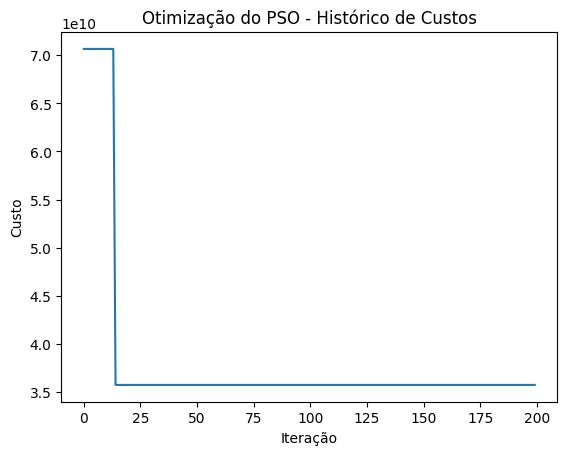

In [979]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteração')
plt.ylabel('Custo')
plt.title('Otimização do PSO - Histórico de Custos')
plt.show()

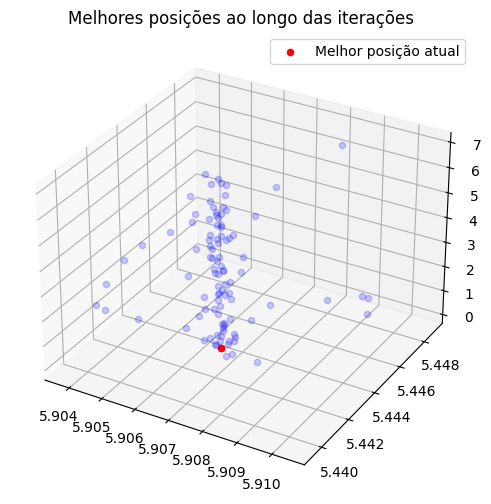

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
                              
Melhor partícula: 35732055781.074524


In [981]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], best_positions[i, 2], c='blue', alpha=0.2)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], best_positions[-1, 2], c='red', label='Melhor posição atual')

ax.set_title('Melhores posições ao longo das iterações')
ax.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")
print("Melhor partícula:", pbest_cost[0])